# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
import pandas as pd
import random

2.0.1+cpu


## Loading the dataset

load the dataset (10% of the data as the test split)

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

proxy = 'http://webproxy:8080'

os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [3]:
achse_mat = scipy.io.loadmat('C:\\Users\\vedurm01\\PycharmProjects\\ZeMA_ML\\ZeMA_Matlab\\Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

sensor_names = ['Mic', 'APB', 'ABB', 'APR', 'AxF', 'Pre', 'Vel', 'ACu', 'MC1', 'MC2', 'MC3']
color_list = ['tab:gray', 'tab:red', 'tab:red', 'tab:red', 'tab:olive', 'tab:green', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

C:\Users\vedurm01\PycharmProjects\GNN_XAI_Captum\venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
ranges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform label encoding
def label_mapping(x):
    return labels[x - 1]

# Perform label encoding
encoded_target = np.digitize(train_target_reshaped, ranges, right=True)
train_target_reshaped = np.vectorize(label_mapping)(encoded_target)

print((train_target_reshaped).shape)

(4766,)


## Convert time-series data to torch geometric graph data. 1. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute. 

## 2. Reduce number of edges by distarding those with a "below average" correlation 

In [5]:
dataset = []
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = torch.tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
    offset = []

    edge_attr = corr_vec[corr_edge_inds[:,0]]
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds.long(), x=torch.tensor(array).float(), edge_attr=torch.tensor(edge_attr).float(), y=torch.tensor([train_target_reshaped[k]]).float())]
random.seed(42)
random.shuffle(dataset)
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [6]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [7]:
y_list = [data.y for data in train_dataset]

## Visualizing the data


In [8]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_mask=None, draw_edge_labels=False, saveplot=False, fname=None, node_weights=None):
    g = g.copy().to_undirected()
#     rng = np.random.default_rng()
#     color_list = rng.choice(['tab:red', 'yellow', 'tab:blue', 'tab:gray'], size=g.number_of_nodes())
    color_list = ['tab:gray', 'tab:red', 'tab:red', 'tab:red', 'tab:olive', 'tab:green', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']
    node_labels = {}
    d = dict(g.degree)
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
        if node_weights is not None:
            node_labels[u]+='\n'+r'$\textbf{{{}}}$'.format(str(round(node_weights[u],2)))
            
    if node_weights is None:
        fontsize = 12
    else:
        fontsize = 9
    
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos, k=0.8, iterations=40)
    if edge_mask is None:
        edge_color = 'black'
        widths = [7*np.abs(g[u][v]['edge_attr'])**.5 for u, v in g.edges()]
        alpha = 0.5
        nx.draw(g, pos=pos, labels=node_labels, width=.5, font_size=fontsize,
        edge_color=edge_color, edge_cmap=plt.cm.Blues,
        node_color=color_list, font_color='#212121', node_size=[(.9+v) * 500 for v in d.values()]
        )
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [7*edge_mask[(u, v)]**.5 for u, v in g.edges()]
        alpha = 0.7
        nx.draw(g, pos=pos, labels=node_labels, width=.45, font_size=fontsize,
                edge_color='white', font_color='#212121',
                node_color=color_list, node_size=[(.9+v) * 300 for v in d.values()]
    )

    nx.draw_networkx_edges(g, pos, width=widths, edge_color=edge_color, alpha=alpha)
    
    if draw_edge_labels:
        if edge_mask is not None:
            edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        else:
            edge_labels = {(u, v): ('%.2f' % attr['edge_attr']) for u, v, attr in g.edges(data=True)}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='#212121', font_size=9, verticalalignment='center', bbox=dict(facecolor='white', alpha=1.0, linewidth=0, boxstyle='square,pad=0.1'))
    
    if saveplot:
        plt.savefig(fname, transparent=True)
        
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])
    for u, data in g.nodes(data=True):
        data['name'] = sensor_names[u]
    return g

## Sample visualization

We sample a single molecule from train_dataset and visualize it

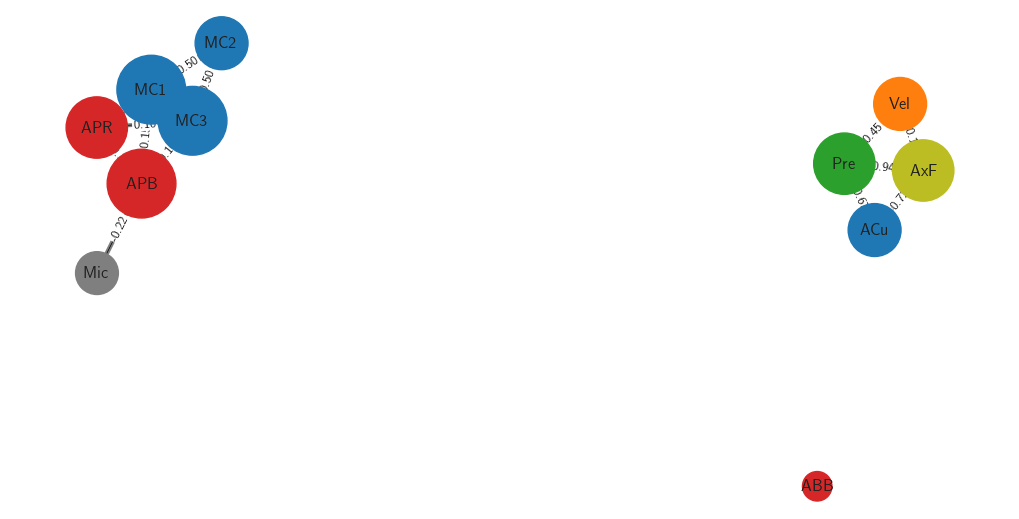

In [9]:
data_1 = random.choice([t for t in train_dataset])
mol = to_molecule(data_1)
plt.figure(figsize=(10, 5))
draw_molecule(mol, draw_edge_labels=True)

In [10]:
mol = to_molecule(data_1)
for u, data in mol.nodes(data=True):
    print(data['name'])

Mic
APB
ABB
APR
AxF
Pre
Vel
ACu
MC1
MC2
MC3


In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool, global_mean_pool
num_features = train_data_reshaped.shape[2]
#num_features = array_fft.shape
num_classes = len(ranges)

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        #num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
#         self.conv4 = GraphConv(dim, dim)
#         self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        #self.lin2 = Linear(dim, dataset.num_classes)
        self.lin2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
#         x = self.conv4(x, edge_index, edge_weight).relu()
#         x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_mean_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [12]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch, data.edge_attr)

        # target = data.y.reshape(-1).long()
        # target = target.view(-1, 1).repeat(1, data.x.size(1)).view(-1)
        # loss = F.nll_loss(output, target)

        loss = F.nll_loss(output, data.y.long())
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch, data.edge_attr)
        pred = output.max(dim=1)[1]
        #print(pred)
        correct += pred.eq(data.y).sum().item()
        #print(correct)
        
    return correct / len(loader.dataset)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
train_acc_values = []
test_acc_values = []
num_epochs = 100
patience = 3
best_val_loss = float('inf')
best_model = None
no_improvement = 0

#for epoch in range(1, 101):
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    loss_values.append(loss)
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Check if validation loss improved
    if len(loss_values) > 1 and loss_values[-1] >= loss_values[-2]:
        no_improvement += 1
    else:
        no_improvement = 0

    # Check if early stopping condition is met
    if no_improvement >= patience:
        print(f"Early stopping. No improvement for {no_improvement} epochs.")
        break


Epoch: 001, Loss: 2.3052, Train Acc: 0.4534, Test Acc: 0.4013
Epoch: 002, Loss: 1.8567, Train Acc: 0.6012, Test Acc: 0.5357
Epoch: 003, Loss: 1.3986, Train Acc: 0.7177, Test Acc: 0.6765
Epoch: 004, Loss: 1.1097, Train Acc: 0.7597, Test Acc: 0.7164
Epoch: 005, Loss: 0.9703, Train Acc: 0.7977, Test Acc: 0.7605
Epoch: 006, Loss: 0.8542, Train Acc: 0.8103, Test Acc: 0.7857
Epoch: 007, Loss: 0.7699, Train Acc: 0.8434, Test Acc: 0.7794
Epoch: 008, Loss: 0.6957, Train Acc: 0.8501, Test Acc: 0.7794
Epoch: 009, Loss: 0.6336, Train Acc: 0.8744, Test Acc: 0.8088
Epoch: 010, Loss: 0.5805, Train Acc: 0.8834, Test Acc: 0.8256
Epoch: 011, Loss: 0.5678, Train Acc: 0.8807, Test Acc: 0.8319
Epoch: 012, Loss: 0.5311, Train Acc: 0.8816, Test Acc: 0.8319
Epoch: 013, Loss: 0.5210, Train Acc: 0.8828, Test Acc: 0.8193
Epoch: 014, Loss: 0.4588, Train Acc: 0.9159, Test Acc: 0.8529
Epoch: 015, Loss: 0.4633, Train Acc: 0.9207, Test Acc: 0.8550
Epoch: 016, Loss: 0.4435, Train Acc: 0.9119, Test Acc: 0.8571
Epoch: 0

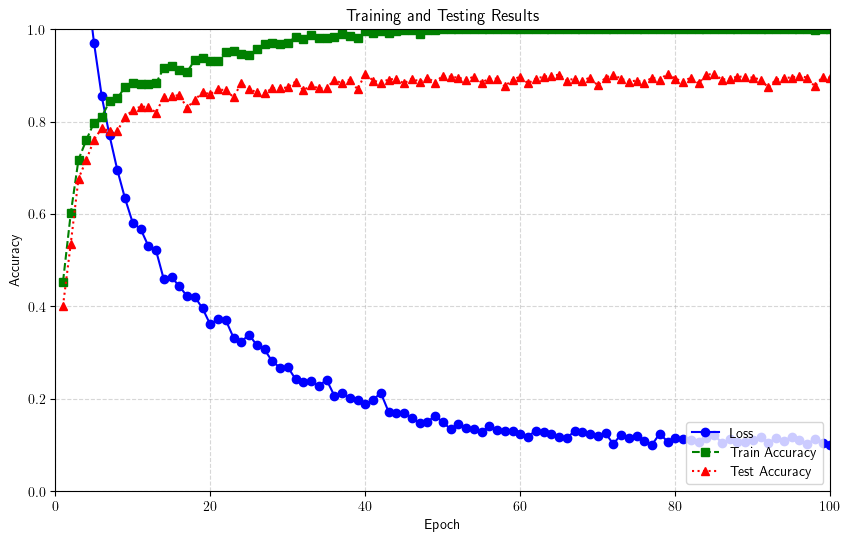

In [14]:
plt.figure(figsize=(10, 6))

losslen = len(loss_values)
epochs = np.arange(1,losslen+1)
# Plot lines with different styles and colors
plt.plot(epochs, loss_values, color='blue', linestyle='-', marker='o', label='Loss')
plt.plot(epochs, train_acc_values, color='green', linestyle='--', marker='s', label='Train Accuracy')
plt.plot(epochs, test_acc_values, color='red', linestyle=':', marker='^', label='Test Accuracy')

# Set title and labels
plt.title('Training and Testing Results')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend and position it
plt.legend(loc='lower right')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust axis limits and ticks
plt.xlim(1, losslen)
plt.xticks(np.arange(0, losslen+1, np.floor(losslen/5)))
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [17]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def model_forward_new(node_attrs, edge_attrs, data):
    batch = torch.zeros(node_attrs.shape[0], dtype=int).to(device)
    out = model(node_attrs, data.edge_index, data.batch, edge_attrs)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'intgrad':
        ig = IntegratedGradients(model_forward_new)
        mask = ig.attribute((data.x, data.edge_attr), target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward_new)
        mask = saliency.attribute((data.x, data.edge_attr), target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    node_mask = np.abs(mask[0].cpu().detach().numpy())
    edge_mask = np.abs(mask[1].cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    if node_mask.max() > 0:  # avoid division by zero
        node_mask = node_mask / node_mask.max()
    return node_mask, edge_mask

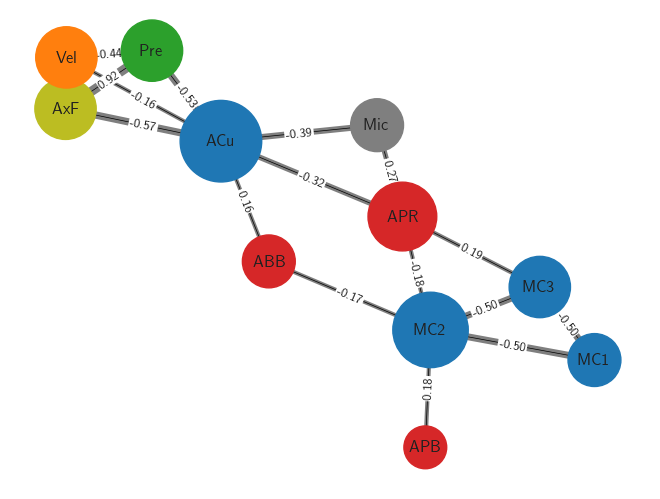

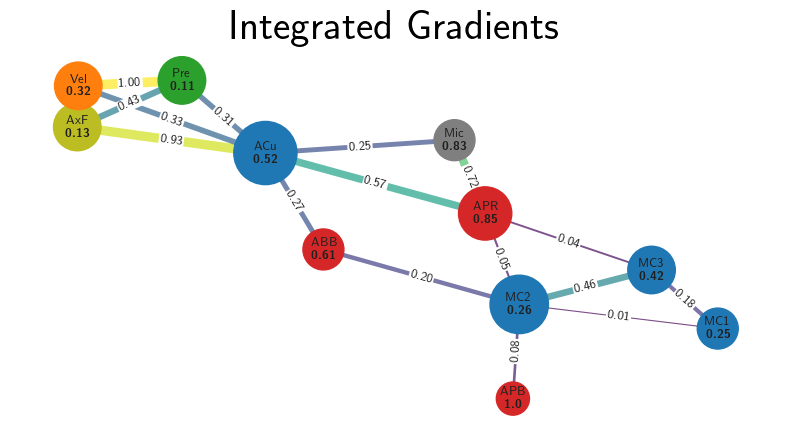

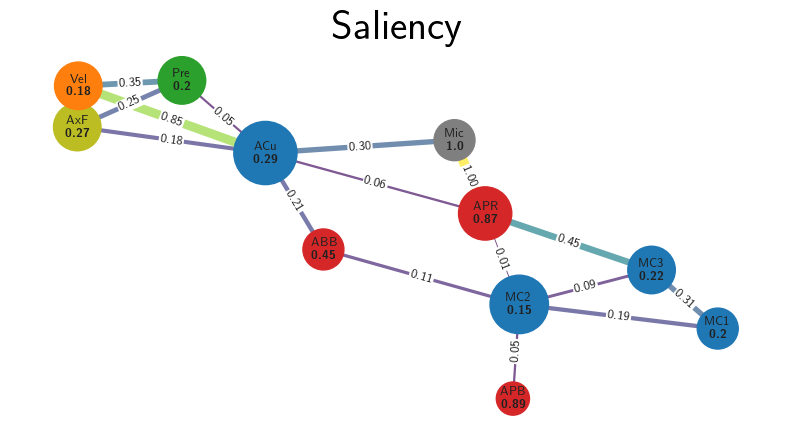

In [18]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        val = val.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

data = test_dataset[111]
output = model(data.x, data.edge_index, data.batch, data.edge_attr)
target = output.max(dim=1)[1]
mol = to_molecule(data)
draw_molecule(mol, draw_edge_labels=True)

for title, method in [('Integrated Gradients', 'intgrad'), ('Saliency', 'saliency')]:
    node_mask, edge_mask = explain(method, data, target=target)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    mean_node_mask = node_mask.mean(axis=1)
    node_mask_norm = mean_node_mask / mean_node_mask.max()
    plt.figure(figsize=(10, 5))
    plt.title(title, fontdict={'fontsize':30})
    draw_molecule(mol, edge_mask=edge_mask_dict, draw_edge_labels=True, saveplot=True, fname=method+'.png', node_weights=node_mask_norm)
#     plt.savefig(method+'.png', transparent=True)

In [ ]:
import matplotlib.colors as clrs
for idx, colorname in enumerate(color_list):
    print(colorname, clrs.to_hex(colorname), sensor_names[idx])

In [ ]:
data = test_dataset[111]  
saliency = Saliency(model_forward_new)
mask = saliency.attribute((data.x, data.edge_attr), target=0,
                                  additional_forward_args=(data,))

In [ ]:
edge_mask

In [ ]:
output = model(data.x, data.edge_index, data.batch, data.edge_attr)
output.max(dim=1)[1]

In [ ]:
batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
model(data.x, data.edge_index, batch, edge_mask)

In [ ]:
data = test_dataset[101]
output = model(data.x, data.edge_index, data.batch)
output.max(dim=1)[1]

In [ ]:
data = test_dataset[101]
torch.flatten(data.edge_attr).requires_grad_(True).to(device)

In [ ]:
data = test_dataset[101]
model(data.x, data.edge_index, data.batch, torch.flatten(data.edge_attr).float().requires_grad_(True).to(device))

In [ ]:
torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)

In [ ]:
[edge_mask_dict[(u, v)].item() for u, v in mol.edges()]

In [ ]:
mean_node_mask = node_mask.mean(axis=1)
mean_node_mask / mean_node_mask.max()

In [ ]:
plt.plot(node_mask[1])

In [ ]:
atemp=.023
plt.title(r'$\textbf{{{}}}$'.format(atemp))
plt.plot(np.linspace(0,100), np.linspace(0,100))